# Performance Evaluator

This notebook defines the model that is responsible for evaluating how toxic the input text is. This is needed to evaluate the performance of the models and see how much less toxic the text was made.

In [2]:
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd

### Preprocessing the data
Here, I lower the text and remove all special symbols because the text's toxicity doesn't depend on the capital letters, or special symbols

In [3]:
df = pd.read_csv('../data/raw/filtered.tsv', sep='\t')
df.head()
df['reference'] = df['reference'].str.lower().str.replace(r"[^a-z0-9\s]", "", regex=True).str.strip()
df['translation'] = df['translation'].str.lower().str.replace(r"[^a-z0-9\s]", "", regex=True).str.strip()

df.head()

,Unnamed: 0,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,0,if alkar is flooding her with psychic waste th...,if alkar floods her with her mental waste it w...,0.785171,0.010309,0.014195,0.981983
1,1,now youre getting nasty,youre becoming disgusting,0.749687,0.071429,0.065473,0.999039
2,2,well we could spare your life for one,well we can spare your life,0.919051,0.268293,0.213313,0.985068
3,3,ah monkey youve got to snap out of it,monkey you have to wake up,0.664333,0.309524,0.053362,0.994215
4,4,ive got orders to put her down,i have orders to kill her,0.726639,0.181818,0.009402,0.999348


In [1]:
# Create DataFrame for reference texts and their toxicity levels
ref_data = df[['reference', 'ref_tox']].rename(columns={'reference': 'text', 'ref_tox': 'toxicity'})

# Create DataFrame for translation texts and their toxicity levels
trn_data = df[['translation', 'trn_tox']].rename(columns={'translation': 'text', 'trn_tox': 'toxicity'})

# data = ref_data.append(trn_data, ignore_index=True)
data = pd.concat([ref_data, trn_data])
data = data[(data['toxicity'] <= 0.3) | (data['toxicity'] >= 0.7)]
print(data.shape)
data[:10000].to_csv('sample.csv')
data = pd.read_csv('sample.csv')

NameError: name 'df' is not defined

### Evening out the distribution for training

In [249]:
from sklearn.utils import resample

majority_class = data[data.toxicity <= 0.7]
minority_class = data[data.toxicity > 0.7]

# Upsample minority class
minority_upsampled = resample(
    minority_class,
    replace=True,  # sample with replacement
    n_samples=len(majority_class),  # match number in majority class
    random_state=42,
)  # reproducible results

# Combine majority class with upsampled minority class
data = pd.concat([majority_class, minority_upsampled])

# Check new class counts
data.toxicity.value_counts()

toxicity
0.977233    9
0.885350    6
0.979246    6
0.987264    6
0.998770    5
           ..
0.005547    1
0.000113    1
0.232639    1
0.007771    1
0.959173    1
Name: count, Length: 7454, dtype: int64

In [250]:
# Function to tokenize the text and build a vocabulary
def tokenize_and_build_vocab(texts):
    # Tokenize the text
    tokenized_texts = [text.lower().split() for text in texts]

    # Count the words
    word_counts = Counter(word for sentence in tokenized_texts for word in sentence)

    # Build the vocabulary - mapping from word to unique index
    # Start indexing from 1 since we'll use 0 for padding
    vocabulary = {word: idx + 1 for idx, (word, _) in enumerate(word_counts.items())}

    return tokenized_texts, vocabulary

# Tokenize text and build vocab
tokenized_texts, vocabulary = tokenize_and_build_vocab(data['text'])

In [251]:
# Maximum sequence length
MAX_SEQ_LEN = max(len(sentence) for sentence in tokenized_texts)

# Convert tokenized texts to sequences of indices
sequences = [[vocabulary[word] for word in sentence] for sentence in tokenized_texts]

# Pad sequences to the maximum sequence length
padded_sequences = [seq + [0] * (MAX_SEQ_LEN - len(seq)) for seq in sequences]

# Convert labels to a list
labels = data['toxicity'].tolist()

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Output the size of the vocabulary and a small part of it for verification
len(vocabulary), dict(list(vocabulary.items())[:10])

(9819,
 {'if': 1,
  'alkar': 2,
  'is': 3,
  'flooding': 4,
  'her': 5,
  'with': 6,
  'psychic': 7,
  'waste': 8,
  'that': 9,
  'explains': 10})

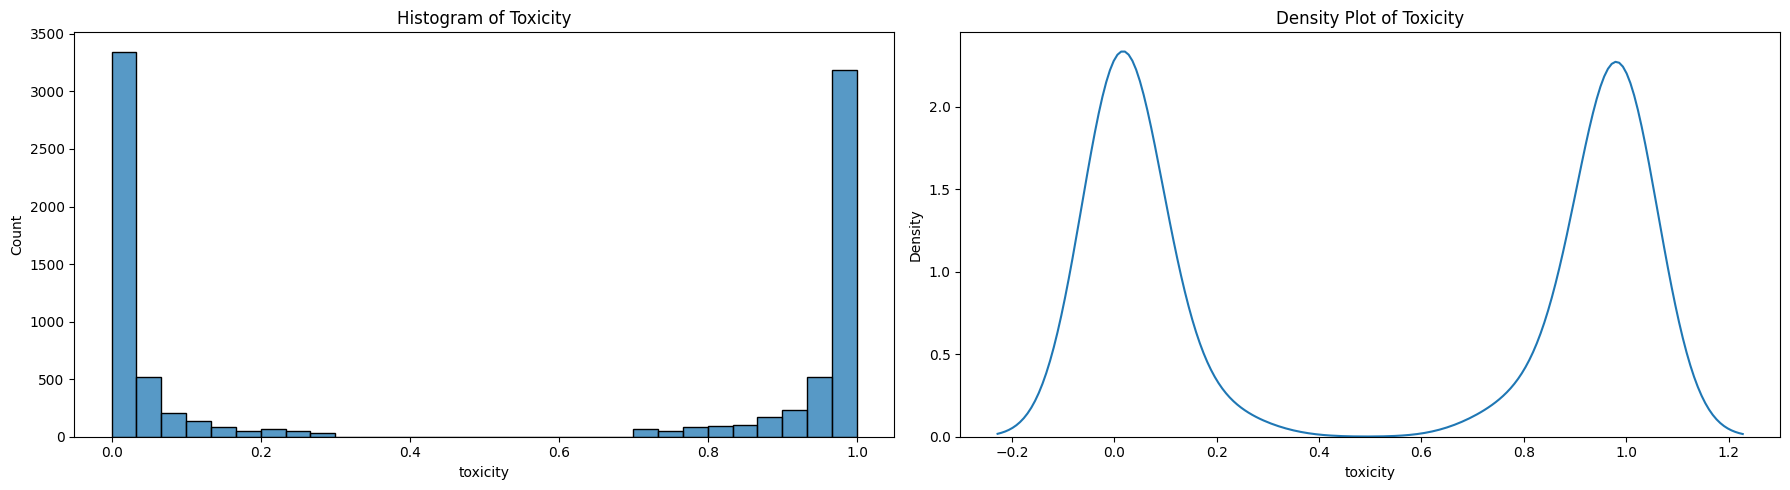

count    8994.000000
mean        0.496686
std         0.469209
min         0.000034
25%         0.008016
50%         0.499402
75%         0.989275
max         0.999712
Name: toxicity, dtype: float64

In [252]:
# Get descriptive statistics
descriptive_stats = data['toxicity'].describe()

# Generate histogram, density plot, and box plot
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Histogram
sns.histplot(data['toxicity'], bins=30, kde=False, ax=axes[0])
axes[0].set_title('Histogram of Toxicity')

# Density Plot
sns.kdeplot(data['toxicity'], ax=axes[1])
axes[1].set_title('Density Plot of Toxicity')

plt.tight_layout()
plt.show()

descriptive_stats

As we can see, the distributions of toxic and non-toxic texts are somewhat equal, which makes the model less biased towards any of the classes.

### Defining the dataset

In [253]:
from torch.utils.data import Dataset, DataLoader
import torch

# Define a custom Dataset class
class TextDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx]), torch.tensor(self.labels[idx], dtype=torch.float32)

# Create Dataset instances for training and validation sets
train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test)

# Create DataLoaders for training and validation sets
batch_size = 32  # You can adjust the batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check the first batch to make sure everything is working
next(iter(train_loader))

[tensor([[  63,  283,  213,  ...,    0,    0,    0],
         [  16,   79,   63,  ...,    0,    0,    0],
         [ 496, 1259,   90,  ...,    0,    0,    0],
         ...,
         [  52,  272,  146,  ...,    0,    0,    0],
         [  65,   66,   11,  ...,    0,    0,    0],
         [  63,  269,   65,  ...,    0,    0,    0]]),
 tensor([9.9388e-01, 1.4715e-02, 4.6061e-05, 3.2364e-02, 9.5224e-01, 1.8657e-02,
         3.3313e-04, 9.9890e-01, 9.9815e-01, 5.9548e-02, 9.9599e-01, 1.2956e-01,
         9.2717e-01, 9.3310e-01, 2.1833e-01, 8.9658e-01, 9.4034e-05, 2.4048e-01,
         9.9928e-01, 3.1970e-03, 5.4368e-05, 1.7776e-02, 7.2012e-01, 9.9954e-01,
         4.5095e-03, 1.1772e-04, 2.6436e-02, 9.9488e-01, 9.8559e-01, 9.4482e-01,
         5.7637e-05, 9.8598e-01])]

### Defining the model

In [254]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(TextClassifier, self).__init__()
        # Embedding layer that turns words into a vector of a specified size
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Fully connected layers
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # Batch normalization
        self.dropout1 = nn.Dropout(dropout_rate)  # Dropout

        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)  # Batch normalization
        self.dropout2 = nn.Dropout(dropout_rate)  # Dropout

        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Pass data through embedding layer
        x = self.embedding(x)

        # The average of the word embeddings
        x = torch.mean(x, dim=1)

        # Pass data through fully-connected layers with ReLU activation function
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        # Output layer with sigmoid activation function
        x = self.fc3(x)

        return x


# Instantiate the model
vocab_size = len(vocabulary) + 1  # +1 for padding index 0
embed_dim = 512  # Size of the word embeddings
hidden_dim = 784  # Size of the hidden layers
output_dim = 1  # Single output for toxicity score


def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        if m.bias is not None:
            m.bias.data.fill_(0.01)


model = TextClassifier(vocab_size, embed_dim, hidden_dim, output_dim).to("mps")

model.apply(init_weights)
model

TextClassifier(
  (embedding): Embedding(9820, 512)
  (fc1): Linear(in_features=512, out_features=784, bias=True)
  (bn1): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=784, out_features=784, bias=True)
  (bn2): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=784, out_features=1, bias=True)
)

In [257]:
min_val_loss = 10e10
train_loss = []
val_loss = []

In [274]:
num_epochs = 100
device = "mps"
loss_fn = nn.MSELoss()


def train(model, train_loader, val_loader):
    global min_val_loss, train_loss, val_loss

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss = 0
        for i, batch in enumerate(train_loader):
            inputs = batch[0].to(device)
            labels = batch[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs).flatten()
            loss = loss_fn(
                outputs, labels.float()
            )  # Ensure labels are float for MSELoss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_loss.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch[0].to(device)
                labels = batch[1].to(device)
                outputs = model(inputs).flatten()
                loss = loss_fn(
                    outputs, labels.float()
                )  # Ensure labels are float for MSELoss
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_loss.append(avg_val_loss)
        print(
            f"Epoch {epoch}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}"
        )
        # Saving the best model as soon as it's created.
        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_evaluator")


train(model, train_loader, val_loader)

Epoch 0: Train Loss: 0.0127, Val Loss: 0.1713
Epoch 1: Train Loss: 0.0132, Val Loss: 0.1809
Epoch 2: Train Loss: 0.0152, Val Loss: 0.2657
Epoch 3: Train Loss: 0.0146, Val Loss: 0.1414
Epoch 4: Train Loss: 0.0143, Val Loss: 0.1924
Epoch 5: Train Loss: 0.0136, Val Loss: 0.2012
Epoch 6: Train Loss: 0.0129, Val Loss: 0.1714
Epoch 7: Train Loss: 0.0129, Val Loss: 0.2399
Epoch 8: Train Loss: 0.0127, Val Loss: 0.1469
Epoch 9: Train Loss: 0.0130, Val Loss: 0.1595
Epoch 10: Train Loss: 0.0127, Val Loss: 0.1715
Epoch 11: Train Loss: 0.0133, Val Loss: 0.2349
Epoch 12: Train Loss: 0.0124, Val Loss: 0.1541
Epoch 13: Train Loss: 0.0116, Val Loss: 0.1781
Epoch 14: Train Loss: 0.0140, Val Loss: 0.1531
Epoch 15: Train Loss: 0.0124, Val Loss: 0.1397
Epoch 16: Train Loss: 0.0137, Val Loss: 0.2056
Epoch 17: Train Loss: 0.0129, Val Loss: 0.1504
Epoch 18: Train Loss: 0.0118, Val Loss: 0.2030
Epoch 19: Train Loss: 0.0114, Val Loss: 0.1554
Epoch 20: Train Loss: 0.0113, Val Loss: 0.1480
Epoch 21: Train Loss: 0

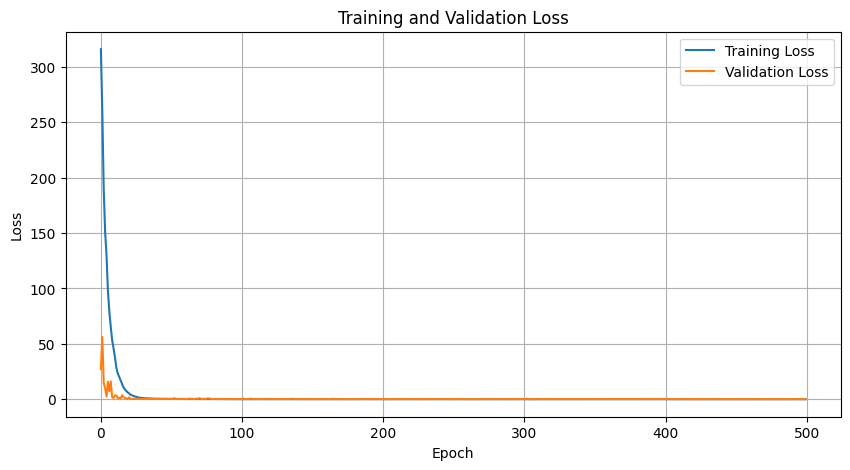

In [275]:
import matplotlib.pyplot as plt

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Testing the model

In [282]:
def evaluate(model, dataloader):
    model.load_state_dict(torch.load('best_evaluator'))
    model.eval()
    optimizer = torch.optim.Adam(model.parameters())

    for i, batch in enumerate(dataloader):
        inputs = batch[0].to(device)
        labels = batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs).flatten()
        loss = loss_fn(outputs, labels)

        if i % 100 == 0:
            print(i, '/', len(dataloader), 'Loss:', loss.item())
            for i in range(32):
                print(labels[i].item(), outputs[i].item())

In [283]:
evaluate(model, train_loader)

0 / 169 Loss: 0.021162789314985275
0.018957087770104408 0.1239703893661499
0.9963453412055969 0.9192773103713989
0.9984588623046875 0.8311715126037598
0.00946585088968277 0.20417943596839905
0.999221920967102 0.8924989700317383
0.9189627170562744 0.8681637048721313
0.8541130423545837 0.4500808119773865
0.9924502372741699 0.830974280834198
0.031145934015512466 0.06250089406967163
0.9967503547668457 0.9482603073120117
0.9339482188224792 0.8799529075622559
0.9508895874023438 0.7453978061676025
0.03676387667655945 0.07261013984680176
0.9877138137817383 0.9496090412139893
7.291758811334148e-05 0.1222628802061081
0.00045856848009862006 0.06274420022964478
4.786606223206036e-05 0.1857748031616211
0.0003469506627880037 0.11556056141853333
0.0010239522671326995 0.20277424156665802
0.9946134686470032 0.8371152877807617
0.9995718598365784 0.9453529119491577
0.9987241625785828 0.9071637988090515
0.9996917247772217 0.8310335278511047
5.505592343979515e-05 0.26967889070510864
0.0018999946769326925 0

As we can see, the model can predict the text's toxicity pretty accurately, and we can use this function to estimate the text detoxification models' performance.